<a href="https://colab.research.google.com/github/MasterNathan01/4105/blob/main/WatersNathan_801283595_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

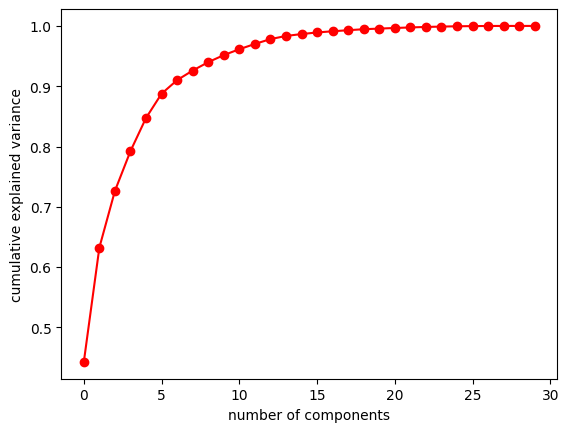

In [15]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

#database
cancer_data = load_breast_cancer()
df_cancer = pd.DataFrame(cancer_data.data, columns = cancer_data.feature_names)
df_cancer['target'] = cancer_data.target

X_cancer = df_cancer.drop('target', axis=1).values
y_cancer = df_cancer['target']

scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

#plot #how much info is retained
pca_full = PCA().fit(X_cancer_scaled)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', color='red')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

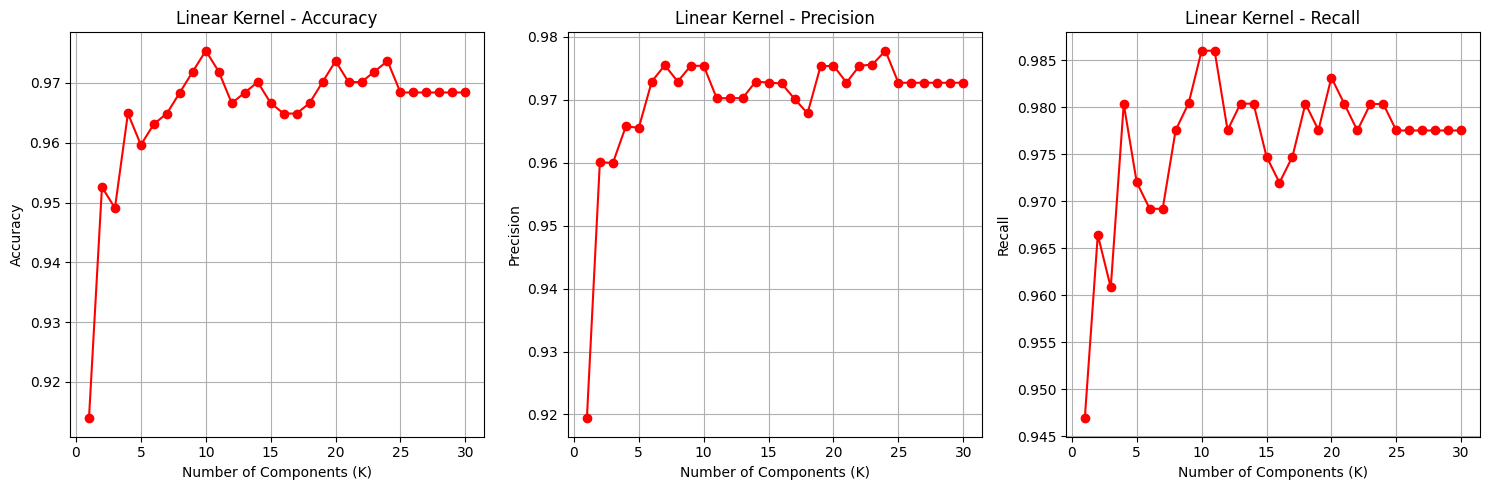

Kernel: linear, Best Accuracy: 0.9754, Optimal Components: 10


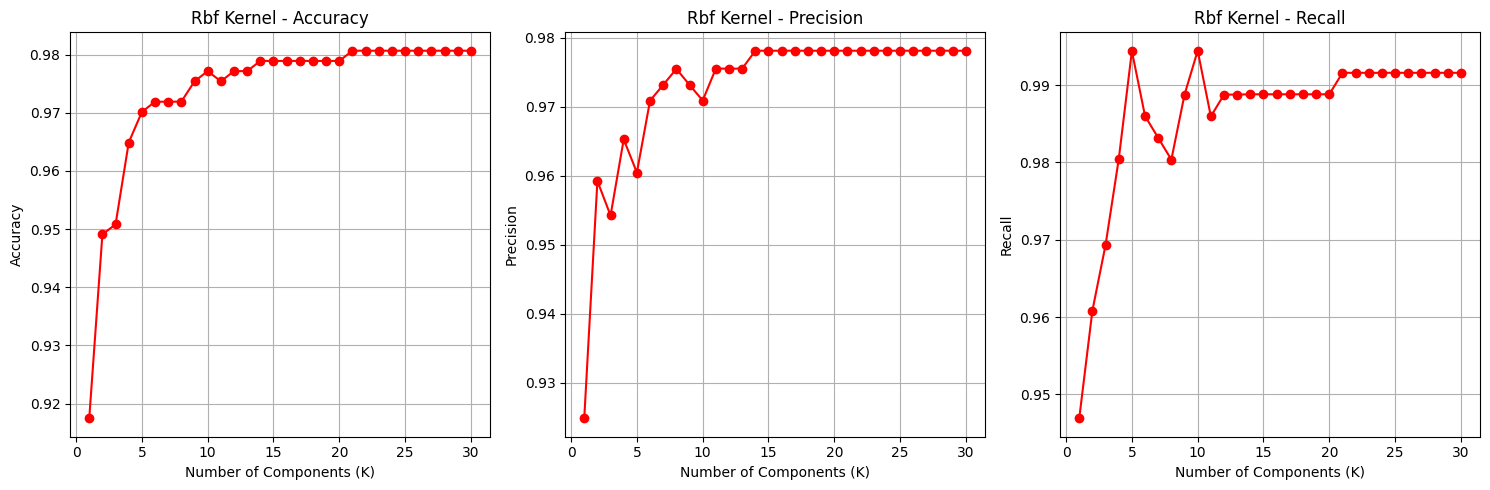

Kernel: rbf, Best Accuracy: 0.9807, Optimal Components: 21


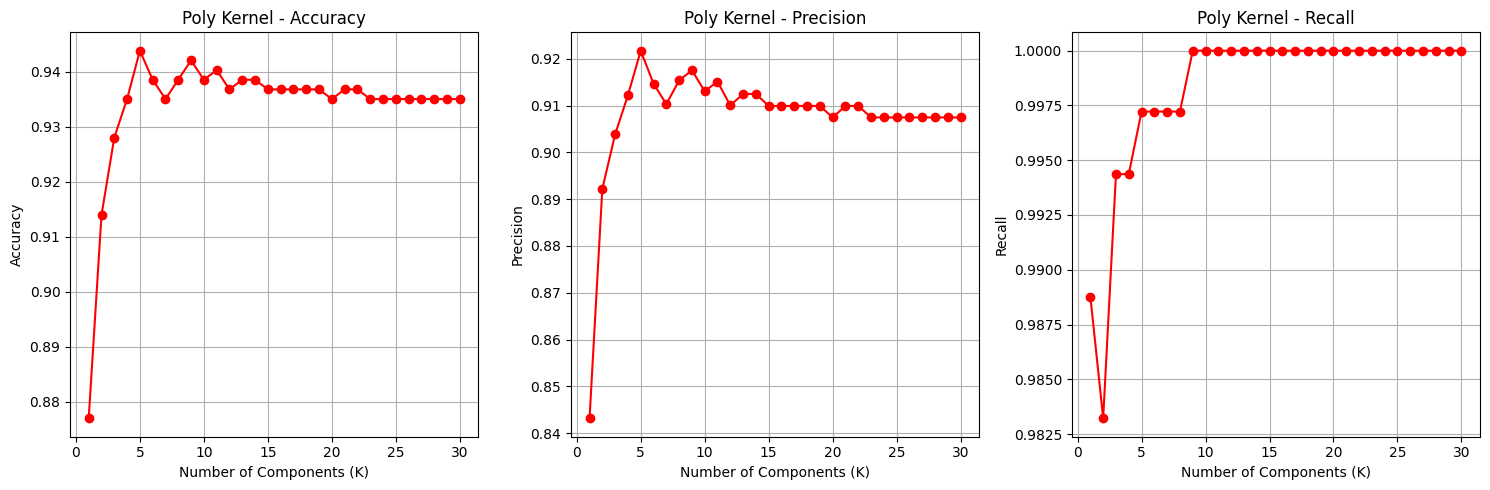

Kernel: poly, Best Accuracy: 0.9438, Optimal Components: 5


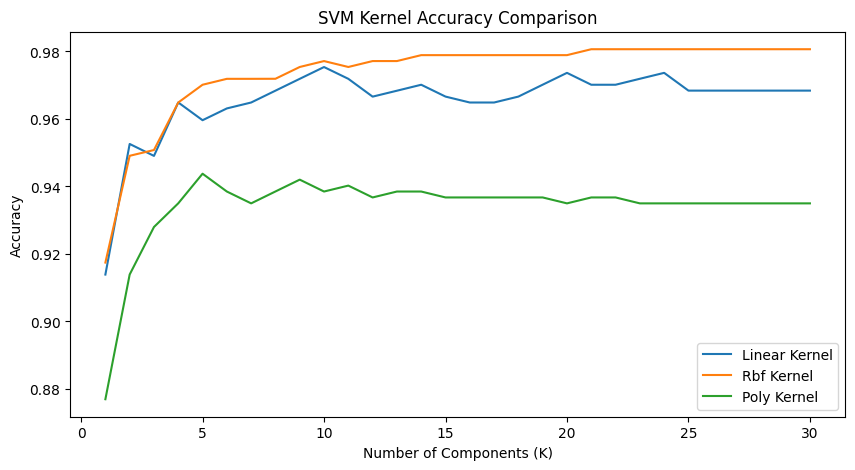

In [16]:
# had to use GridSearchCV becasue without it, my rbf kernel was failing to preform becuase...
# ... it was choosing either C or gamma and not taking into account both
def perform_svm_pca_cv(features, labels, kernel, component_range, C=3, gamma='scale', param_grid=None):
    """
    Args:
    features: input data matix
    labels: target labels
    kernel: SVM kernel type
    component_range: range of PCA
    C: SVM regularization parameter
    gamma: SVM kernel coefficient
    param_grid: param_grid for GridSearchCV

  Returns:
    dict: metrcis for each component
    float: best accuracy achieved
    int: optimal
    """
    metrics_data = {'accuracy': [], 'precision': [], 'recall': []}
    best_accuracy, optimal_components = 0, None

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for k in component_range:
        pca = PCA(n_components=k)
        X_reduced = pca.fit_transform(features)

        fold_accuracies = []
        fold_precisions = []
        fold_recalls = []

        if param_grid and kernel == 'rbf':
            svm = SVC(kernel=kernel)
            grid_search = GridSearchCV(svm, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_reduced, labels)
            best_params = grid_search.best_params_
            svm_model = SVC(kernel=kernel, **best_params)
        else:
            svm_model = SVC(kernel=kernel, C=C, gamma=gamma)

        for train_index, test_index in skf.split(X_reduced, labels):
            X_train, X_test = X_reduced[train_index], X_reduced[test_index]
            y_train, y_test = labels[train_index], labels[test_index]

            svm_model.fit(X_train, y_train)
            predictions = svm_model.predict(X_test)

            acc = accuracy_score(y_test, predictions)
            prec = precision_score(y_test, predictions)
            rec = recall_score(y_test, predictions)

            fold_accuracies.append(acc)
            fold_precisions.append(prec)
            fold_recalls.append(rec)

        avg_acc = np.mean(fold_accuracies)
        avg_prec = np.mean(fold_precisions)
        avg_rec = np.mean(fold_recalls)

        metrics_data['accuracy'].append(avg_acc)
        metrics_data['precision'].append(avg_prec)
        metrics_data['recall'].append(avg_rec)

        if avg_acc > best_accuracy:
            best_accuracy = avg_acc
            optimal_components = k

    return metrics_data, best_accuracy, optimal_components

def plot_svm_metrics(metrics, component_range, kernel_type):
    """
    Args:
        metrics: data for plotting.
        component_range: PCA component range.
        kernel_type: SVM kernel
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for idx, metric in enumerate(['accuracy', 'precision', 'recall']):
        axes[idx].plot(component_range, metrics[metric], marker='o', color='red')
        axes[idx].set_title(f'{kernel_type.capitalize()} Kernel - {metric.capitalize()}')
        axes[idx].set_xlabel('Number of Components (K)')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

component_range = list(range(1, 31))
kernels = ['linear', 'rbf', 'poly']

param_grid_rbf = {'C': [0.1, 1, 10, 100],'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}

for kernel in kernels:
    if kernel == 'rbf':
        metrics, best_acc, best_k = perform_svm_pca_cv(X_cancer_scaled, y_cancer, kernel, component_range, param_grid=param_grid_rbf)
    else:
        metrics, best_acc, best_k = perform_svm_pca_cv(X_cancer_scaled, y_cancer, kernel, component_range)

    plot_svm_metrics(metrics, component_range, kernel)
    print(f"Kernel: {kernel}, Best Accuracy: {best_acc:.4f}, Optimal Components: {best_k}")

plt.figure(figsize=(10, 5))
for kernel in kernels:
    if kernel == 'rbf':
        metrics, _, _ = perform_svm_pca_cv(X_cancer_scaled, y_cancer, kernel, component_range, param_grid=param_grid_rbf)
    else:
        metrics, _, _ = perform_svm_pca_cv(X_cancer_scaled, y_cancer, kernel, component_range)
    plt.plot(component_range, metrics['accuracy'], label=f'{kernel.capitalize()} Kernel')

plt.xlabel('Number of Components (K)')
plt.ylabel('Accuracy')
plt.title('SVM Kernel Accuracy Comparison')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


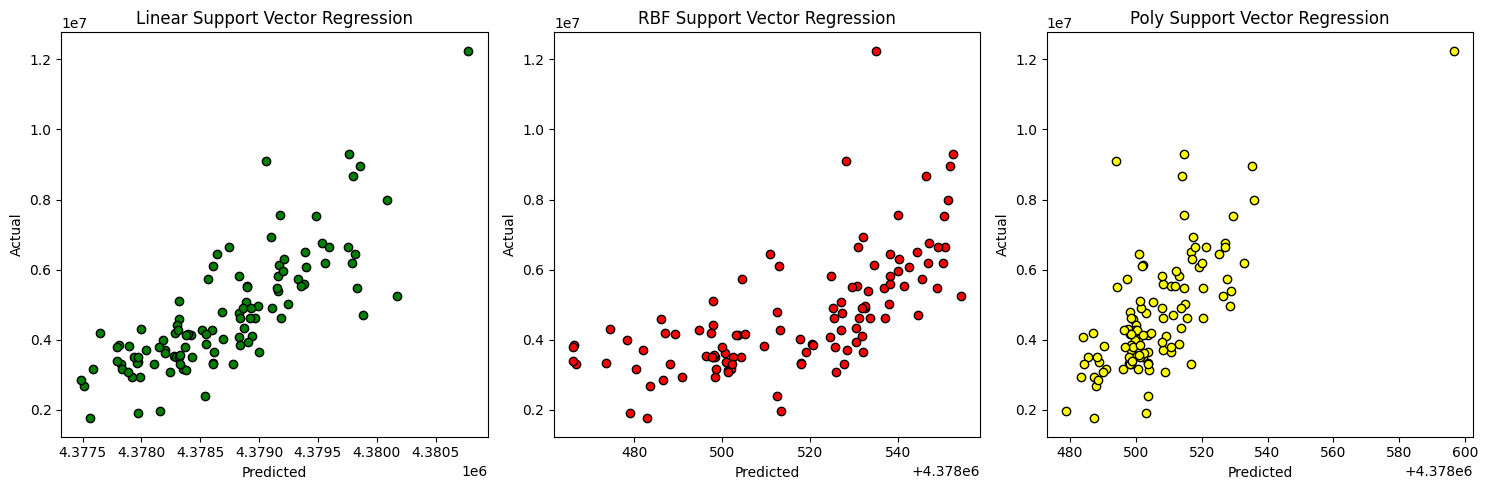

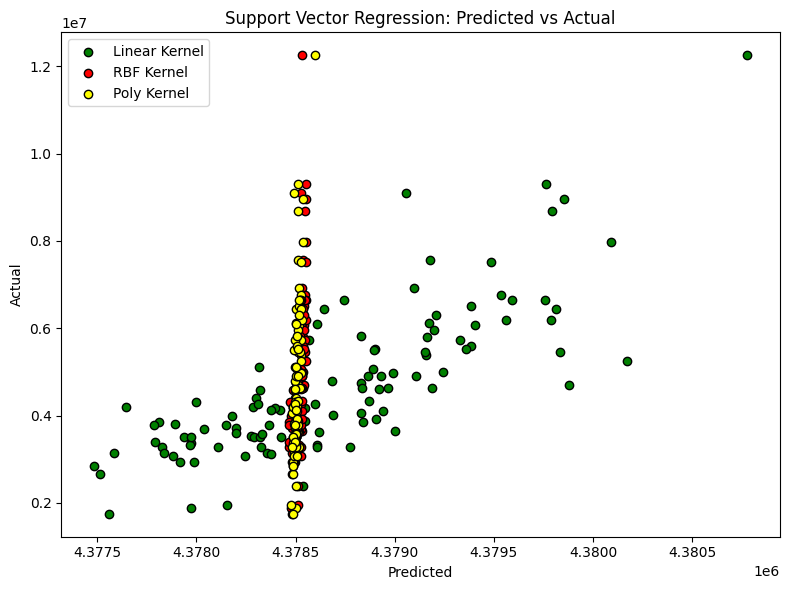

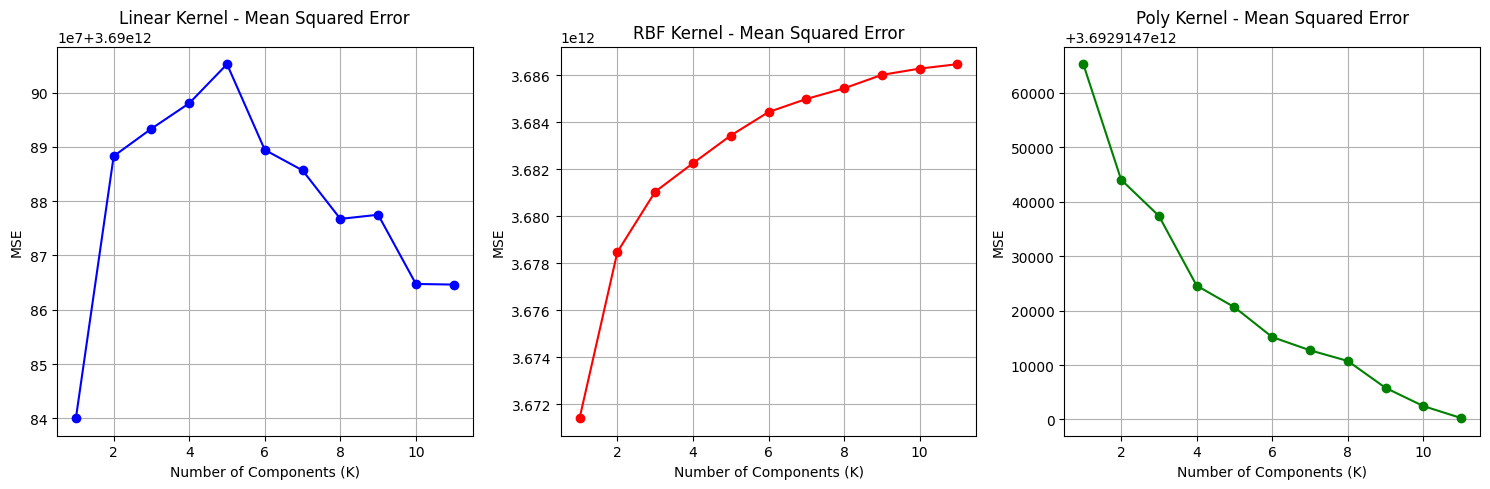

Linear Kernel - Optimal Components: 1, Lowest MSE: 3690840057061.9053
RBF Kernel - Optimal Components: 1, Lowest MSE: 3671413921391.4365
Poly Kernel - Optimal Components: 11, Lowest MSE: 3692914700269.1548


In [22]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

housing_url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv'
housing_df =  pd.read_csv(housing_url)

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

housing_df[varlist] = housing_df[varlist].apply(binary_map)

housing_df = housing_df.drop('furnishingstatus', axis=1)

X = housing_df.drop('price', axis=1)
y = housing_df['price'].values.reshape(-1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

svr_rbf = SVR(kernel='rbf', C=1, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1)
svr_poly = SVR(kernel='poly', C=1, degree=2)

y_rbf_pred = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin_pred = svr_lin.fit(X_train, y_train).predict(X_test)
y_poly_pred = svr_poly.fit(X_train, y_train).predict(X_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_lin_pred, y_test, color='green', edgecolor='k')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Linear Support Vector Regression')

plt.subplot(1, 3, 2)
plt.scatter(y_rbf_pred, y_test, color='red', edgecolor='k')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RBF Support Vector Regression')

plt.subplot(1, 3, 3)
plt.scatter(y_poly_pred, y_test, color='yellow', edgecolor='k')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Poly Support Vector Regression')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

#together
plt.scatter(y_lin_pred, y_test, color='green', edgecolor='k', label='Linear Kernel')
plt.scatter(y_rbf_pred, y_test, color='red', edgecolor='k', label='RBF Kernel')
plt.scatter(y_poly_pred, y_test, color='yellow', edgecolor='k', label='Poly Kernel')


plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Support Vector Regression: Predicted vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

def svr_train_cv(X, y, kernel_type, component_range, C=1, gamma =0.01, param_grid=None):
  mse_scores = []
  best_mse, optimal_components = float('inf'), None
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  for k in component_range:
    pca = PCA(n_components=k)
    X_reduced = pca.fit_transform(X)

    if param_grid and kernel_type == 'rbf':
        svr = SVR(kernel=kernel_type)
        grid_search = GridSearchCV(svr, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_reduced, y.ravel())
        best_params = grid_search.best_params_
        svr_model = SVR(kernel=kernel_type, **best_params)
    else:
        svr_model = SVR(kernel=kernel_type, C=C, gamma=gamma)

    fold_mse = []

    for train_index, test_index in kf.split(X_reduced):
      X_train_cv, X_test_cv = X_reduced[train_index], X_reduced[test_index]
      y_train_cv, y_test_cv = y[train_index], y[test_index]

      svr_model.fit(X_train_cv, y_train_cv.ravel())
      y_pred_cv = svr_model.predict(X_test_cv)
      mse = mean_squared_error(y_test_cv, y_pred_cv)
      fold_mse.append(mse)

    avg_mse = np.mean(fold_mse)
    mse_scores.append(avg_mse)

    if avg_mse < best_mse:
       best_mse = avg_mse
       optimal_components = k

  return mse_scores, best_mse, optimal_components

component_range = list(range(1, 12))
kernels = ['linear', 'rbf', 'poly']

param_grid_svr = {'C': [0.1, 1, 10, 100],'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],'epsilon': [0.01, 0.1, 1]}

lin_mse_scores, lin_mse, lin_K = svr_train_cv(X_scaled, y, 'linear', component_range)
rbf_mse_scores, rbf_mse, rbf_K = svr_train_cv(X_scaled, y, 'rbf', component_range, param_grid=param_grid_svr)
poly_mse_scores, poly_mse, poly_K = svr_train_cv(X_scaled, y, 'poly', component_range)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(component_range, lin_mse_scores, marker='o', color='blue')
plt.title('Linear Kernel - Mean Squared Error')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(component_range, rbf_mse_scores, marker='o', color='red')
plt.title('RBF Kernel - Mean Squared Error')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(component_range, poly_mse_scores, marker='o', color='green')
plt.title('Poly Kernel - Mean Squared Error')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f'Linear Kernel - Optimal Components: {lin_K}, Lowest MSE: {lin_mse:.4f}')
print(f'RBF Kernel - Optimal Components: {rbf_K}, Lowest MSE: {rbf_mse:.4f}')
print(f'Poly Kernel - Optimal Components: {poly_K}, Lowest MSE: {poly_mse:.4f}')